# Ajuste de imagens do interferômetro

### Bibliotecas

In [19]:
%matplotlib nbagg
from typing import Tuple
import scipy
import numpy as np
import math
from PIL import Image, ImageFilter,ImageEnhance
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.backend_bases import MouseButton
from scipy.fft import fft, ifft
from scipy.ndimage import gaussian_filter
from mpl_point_clicker import clicker
import mplcursors

from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase

## Converter imagens em bmp

## Procedimentos de cortes e rotação da imagem

In [20]:
#Transformar Imagens do interferograma em arrays
originalimg1 = Image.open('im1.bmp')# jato de gás
originalimg2 = Image.open('im2.bmp')# referência

originalgas = (np.asarray(originalimg1))[:,:,0]
originalref = (np.asarray(originalimg2))[:,:,0]

<IPython.core.display.Javascript object>


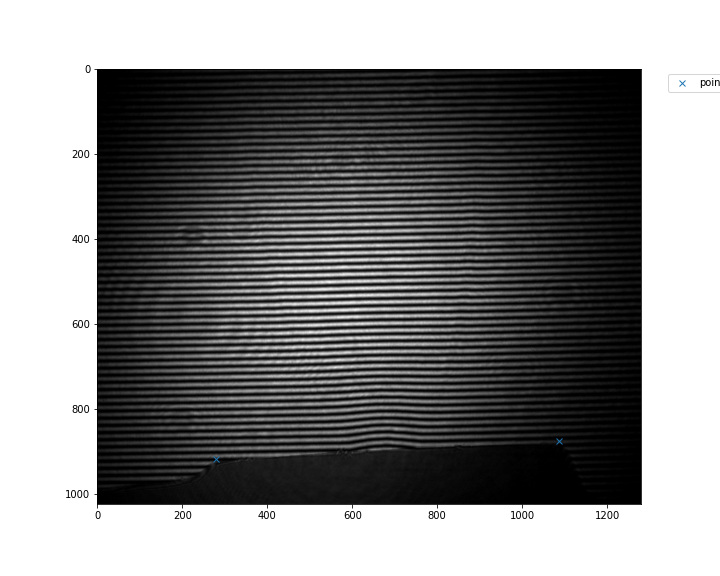

In [21]:
%matplotlib nbagg
#Determinar pontos de referência para corte e rotação
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(originalgas, cmap='gray')
klicker = clicker(ax, ['points'], markers=['x'])


def point_added_cb(position: Tuple[float, float], klass: str):
    x, y = position
    print(f"New point of class {klass} added at {x=}, {y=}")


def point_removed_cb(position: Tuple[float, float], klass: str, idx):
    x, y = position

    suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(idx, 'th')
    print(
        f"The {idx}{suffix} point of class {klass} with position {x=:.2f}, {y=:.2f}  was removed"
    )

klicker.on_point_added(point_added_cb)
klicker.on_point_removed(point_removed_cb)

plt.show()

In [22]:
#Pontos de referência
#print(klicker.get_positions())
coord = (klicker.get_positions())['points']

#determinação da reta de corte do nozzle
Y = [coord[0][1],coord[1][1]]
Ymax = np.min(Y)
Ymin = np.max(Y)

X = [coord[0][0],coord[1][0]]
Xmax = np.max(X)
Xmin = np.min(X)

deltaX = Xmax - Xmin
deltaY = Ymax - Ymin
Acoef = float(deltaY/deltaX)
Bcoef = (Ymin - Acoef*Xmin)

#print(deltaX)
#print(Acoef, Bcoef)

#Relação pixel para cm, pelo comprimento da borda do nozzle
factor_conv = 0.2/deltaX #pixel pra cm
print(factor_conv)

0.00024763119533527703


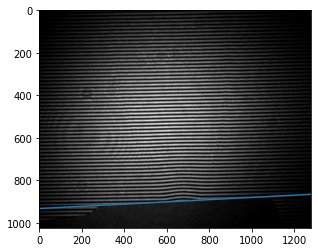

In [23]:
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(originalgas, cmap='gray')
x = np.arange(0,1280)
ax.plot(x,Acoef*x+Bcoef)
plt.show()

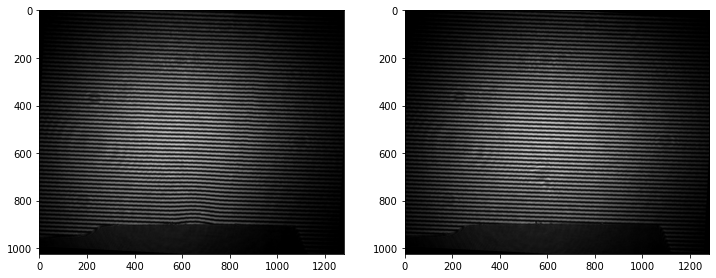

In [24]:
# Rotacionar imagem
degrees_Acoef = math.degrees(math.atan2(deltaY,deltaX))

rotatedimg1 = originalimg1.rotate(degrees_Acoef)
rotatedimg2 = originalimg2.rotate(degrees_Acoef)

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(rotatedimg1, cmap='gray')
axs[1].imshow(rotatedimg2, cmap='gray')


<IPython.core.display.Javascript object>


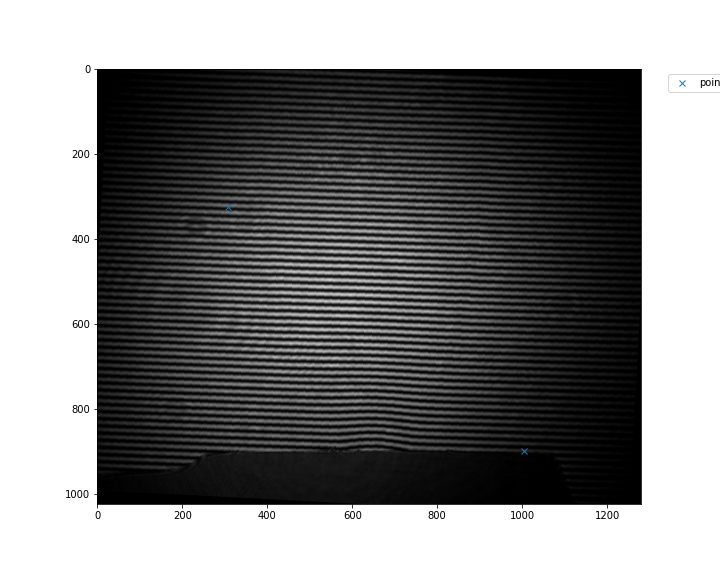

1

In [37]:
#Determinar pontos de referência para corte quadrado - área de interesse de análise
%matplotlib nbagg
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(rotatedimg1, cmap='gray')
klicker2 = clicker(ax, ['points'], markers=['x'])


def point_added_cb(position: Tuple[float, float], klass: str):
    x, y = position
    print(f"New point of class {klass} added at {x=}, {y=}")


def point_removed_cb(position: Tuple[float, float], klass: str, idx):
    x, y = position

    suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(idx, 'th')
    print(
        f"The {idx}{suffix} point of class {klass} with position {x=:.2f}, {y=:.2f}  was removed"
    )

klicker2.on_point_added(point_added_cb)
klicker2.on_point_removed(point_removed_cb)

{'points': array([[ 280.08130979,  918.05481972],
       [1087.73399558,  875.67071376]])}


<IPython.core.display.Javascript object>


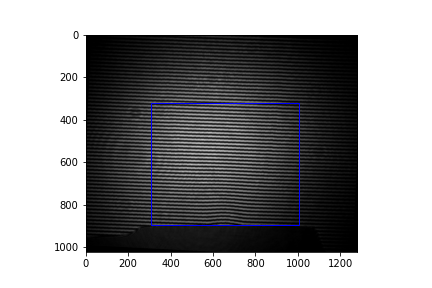

In [38]:
print(klicker.get_positions())
%matplotlib nbagg
fig, ax = plt.subplots()
ax.imshow(rotatedimg1, cmap='gray')


coord_ret = (klicker2.get_positions())['points']

Y_ret = [coord_ret[1][1],coord_ret[0][1]]

X_ret = [coord_ret[1][0],coord_ret[0][0]]

deltaX_ret = abs(np.max(X_ret) - np.min(X_ret))
deltaY_ret = abs(np.max(Y_ret) - np.min(Y_ret))

ax.add_patch(patches.Rectangle((np.min(X_ret), np.min(Y_ret) ), deltaX_ret, deltaY_ret, 
                               edgecolor = 'blue', facecolor = 'red', fill=False) )

plt.show()

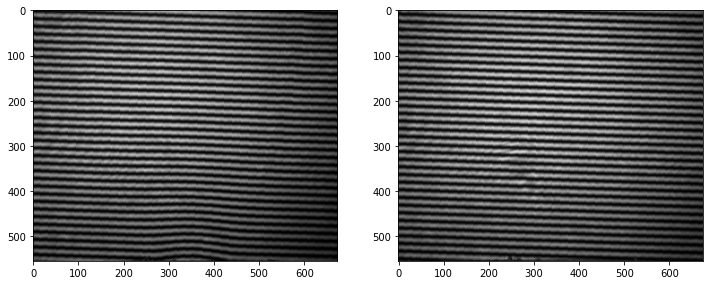

In [35]:
#Recortar Imagem
%matplotlib inline
rotated1 = np.asarray(rotatedimg1)
ajustedimg1 = rotated1[int(np.min(Y_ret)):int(np.max(Y_ret)),
                      int(np.min(X_ret)):int(np.max(X_ret))]#[300:int(Ymax)-20,200:1080]

rotated2 = np.asarray(rotatedimg2)
ajustedimg2 = rotated2[int(np.min(Y_ret)):int(np.max(Y_ret)),
                      int(np.min(X_ret)):int(np.max(X_ret))]#[300:int(Ymax)-20,200:1080]

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(ajustedimg1, cmap='gray')
axs[1].imshow(ajustedimg2, cmap='gray')

In [36]:
img1 = Image.fromarray(ajustedimg1)
img1.save("imajustedst1.bmp")

img2 = Image.fromarray(ajustedimg2)
img2.save("imajustedst2.bmp")